# Detection of Cyberbullying on Twitter

Dataset file from: J. Wang, K. Fu, C.T. Lu, “SOSNet: A Graph Convolutional Network Approach to Fine-Grained Cyberbullying Detection,” Proceedings of the 2020 IEEE International Conference on Big Data (IEEE BigData 2020), December 10-13, 2020.

<img src = 'https://youthlegalserviceinc.com.au/wp-content/uploads/2021/11/1500x750-logos.gif'></img>


## PLAN:

* __Preparing the datasets:__

    We split the dataset into input features (X) and target variable (y) which stand for tweet texts and oh_label/type of cyberbullying. So, basically X will consist of the text column, and y will be the binary label indicating whether a tweet is potentially harmful or not in the first model and multiple labels for further classification.
    Also was performed necessary preprocessing steps on the text data, such as removing stopwords, changing emoticons, getting rid of unicodes, extra links, text went through tokenization, and normalization.


* __Splitting the data into training and testing sets:__

    Then we split the preprocessed data into training and testing subsets to evaluate the model's performance.


* __Vectorizing the text data:__

    We converted the preprocessed text data into a numerical representation that machine learning algorithms can work with. Firstly we used techniques like word embeddings, then TF-IDF to vectorize the text.


* __Training a classification model:__

    Chose a suitable machine learning algorithm for binary and multiple classification, such as logistic regression, random forest, k neighbours, decision tree, naive bayes, neural networks and so on.
    Fitted the model on the training data, using the vectorized text data (X) and the target labels (y).


* __Evaluate the model:__

    Predicted the labels for the test set using the trained model.
    Evaluated the model's performance using metrics like accuracy, precision, recall, and F1-score by scikit-learn library computation tools.

## UNZIPPING DATASETS

In [1]:
zip_path = r'archive.zip'
path = r'archive/'
import zipfile
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(path)

## LIBRARIES

In [74]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB

from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from gensim.models.phrases import Phrases, Phraser

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

import spacy
nlp = spacy.load("en_core_web_sm")

import time

import warnings
warnings.filterwarnings("ignore")

In [119]:
df = pd.read_csv(r'archive/twitter_parsed_dataset.csv')
df

,index,id,Text,Annotation,oh_label
0,5.74948705591165E+017,5.74948705591165E+017,@halalflaws @biebervalue @greenlinerzjm I read...,none,0.0
1,5.71917888690393E+017,5.71917888690393E+017,@ShreyaBafna3 Now you idiots claim that people...,none,0.0
2,3.90255841338601E+017,3.90255841338601E+017,"RT @Mooseoftorment Call me sexist, but when I ...",sexism,1.0
3,5.68208850655916E+017,5.68208850655916E+017,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",racism,1.0
4,5.75596338802373E+017,5.75596338802373E+017,#mkr No No No No No No,none,0.0
...,...,...,...,...,...
16846,5.75606766236475E+017,5.75606766236475E+017,"Feeling so sorry for the girls, they should be...",none,0.0
16847,5.72333822886326E+017,5.72333822886326E+017,#MKR 'pretty good dishes we're happy with' - O...,none,0.0
16848,5.72326950057845E+017,5.72326950057845E+017,RT @colonelkickhead: Deconstructed lemon tart!...,none,0.0
16849,5.74799612642357E+017,5.74799612642357E+017,@versacezaynx @nyazpolitics @greenlinerzjm You...,none,0.0


In [120]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16851 entries, 0 to 16850
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   index       16851 non-null  object 
 1   id          16850 non-null  object 
 2   Text        16850 non-null  object 
 3   Annotation  16848 non-null  object 
 4   oh_label    16848 non-null  float64
dtypes: float64(1), object(4)
memory usage: 658.4+ KB


In [121]:
df.columns = df.columns.str.lower()
df["text"] = df["text"].astype(str)
df.drop(["index","id"], axis=1, inplace=True)

In [7]:
df

,text,annotation,oh_label
0,@halalflaws @biebervalue @greenlinerzjm I read...,none,0.0
1,@ShreyaBafna3 Now you idiots claim that people...,none,0.0
2,"RT @Mooseoftorment Call me sexist, but when I ...",sexism,1.0
3,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",racism,1.0
4,#mkr No No No No No No,none,0.0
...,...,...,...
16846,"Feeling so sorry for the girls, they should be...",none,0.0
16847,#MKR 'pretty good dishes we're happy with' - O...,none,0.0
16848,RT @colonelkickhead: Deconstructed lemon tart!...,none,0.0
16849,@versacezaynx @nyazpolitics @greenlinerzjm You...,none,0.0


## DATA PREPROCESSING

In [8]:
def read_dict_from_file(filename, file):
    filename = {}
    with open(file, 'r', encoding = 'utf8') as f:
        for line in f:
            key, value = line.strip().split('\t')
            filename[key.strip()] = value.strip()
    return filename

In [9]:
emo = {}
uni = {}
shorts = {}
read_dict_from_file(uni, 'uni.txt')
read_dict_from_file(emo, 'emo.txt')
read_dict_from_file(shorts, 'shorthands.txt')

{"ain't": 'is not',
 "aren't": 'are not',
 "can't": 'cannot',
 "can't've": 'cannot have',
 "'cause": 'because',
 "could've": 'could have',
 "couldn't": 'could not',
 "couldn't've": 'could not have',
 "didn't": 'did not',
 "doesn't": 'does not',
 "don't": 'do not',
 "hadn't": 'had not',
 "hadn't've": 'had not have',
 "hasn't": 'has not',
 "haven't": 'have not',
 "he'd": 'he would',
 "he'd've": 'he would have',
 "he'll": 'he will',
 "he'll've": 'he he will have',
 "he's": 'he is',
 "how'd": 'how did',
 "how'd'y": 'how do you',
 "how'll": 'how will',
 "how's": 'how is',
 "i'd": 'i would',
 "i'd've": 'i would have',
 "i'll": 'i will',
 "i'll've": 'i will have',
 "i'm": 'i am',
 "i've": 'i have',
 "isn't": 'is not',
 "it'd": 'it would',
 "it'd've": 'it would have',
 "it'll": 'it will',
 "it'll've": 'it will have',
 "it's": 'it is',
 "let's": 'let us',
 "ma'am": 'madam',
 "mayn't": 'may not',
 "might've": 'might have',
 "mightn't": 'might not',
 "mightn't've": 'might not have',
 "must've": '

In [10]:
def convert_emoticons(text):
    for emot in emo:
        text = re.sub(u'('+emot+u')', "_".join(emo[emot].replace(",","").split()), text)
    return text

def convert_emojis(text):
    for emot in uni:
        text = re.sub(r'('+emot+')', "_".join(uni[emot].replace(",","").replace(":","").split()), text)
    return text

def convert_shorts(text):
    for short in shorts:
        text = re.sub(r'('+short+')', "_".join(shorts[short].replace(",","").replace(":","").split()), text)
    return text

with open('abbr.txt', 'r') as f:
    abbrs = f.read()

In [11]:
abbr_dict = {}
abbr_list = []
for line in abbrs.split("\n"):
    if line != "":
        cw = line.split("=")[0]
        cw_expanded = line.split("=")[1]
        abbr_list.append(cw)
        abbr_dict[cw] = cw_expanded
abbr_list = set(abbr_list)

def abbr_conversion(text):
    new_text = []
    for w in text.split():
        if w.upper() in abbr_list:
            new_text.append(abbr_dict[w.upper()])
        else:
            new_text.append(w)
    return " ".join(new_text)

In [12]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    tokenized = nltk.word_tokenize(text)
    return ' '.join([lemmatizer.lemmatize(words) for words in tokenized])

In [118]:
def cleaning(data):
    data = convert_shorts(data)
    data = convert_emoticons(data)
    data = convert_emojis(data)
    data = abbr_conversion(data)
    data = data.lower()
    data = re.sub(r"(?:\@|https?\://)\S+", '', data)
    data = re.sub('\w*\d\w', '', data)
    data = re.sub(r'[^\x00-\x7f]',r'', data)
    data = re.sub(r'\n', ' ', data)
    data = re.sub("[''""...“”‘’…!?,#;:`&]", '', data)
    data =" ".join([word for word in str(data).split() if word not in stop_words])
    data = lemmatize_words(data)
    return data

In [122]:
df['cleaned'] = df['text'].apply(lambda x: cleaning(x))
# df['cleaned'] = df['cleaned'].apply(lambda x: nltk.word_tokenize(x))
df

,text,annotation,oh_label,cleaned
0,@halalflaws @biebervalue @greenlinerzjm I read...,none,0.0,read contextno change meaning history islamic ...
1,@ShreyaBafna3 Now you idiots claim that people...,none,0.0,idiot claim people tried stop becoming terrori...
2,"RT @Mooseoftorment Call me sexist, but when I ...",sexism,1.0,rt call sexist go auto place id rather talk guy
3,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",racism,1.0,wrong isi follows example mohammed quran exactly
4,#mkr No No No No No No,none,0.0,mkr
...,...,...,...,...
16846,"Feeling so sorry for the girls, they should be...",none,0.0,feeling sorry girl safe kat andre going home mkr
16847,#MKR 'pretty good dishes we're happy with' - O...,none,0.0,mkr pretty good dish happy - ok well im never ...
16848,RT @colonelkickhead: Deconstructed lemon tart!...,none,0.0,rt deconstructed lemon tartcan please go one s...
16849,@versacezaynx @nyazpolitics @greenlinerzjm You...,none,0.0,stupid talk blocked


In [123]:
df.drop(["text"], axis=1, inplace=True)
df.dropna(inplace=True)
# df.to_csv('data.csv', index = False)

## DATA VISUALIZATION

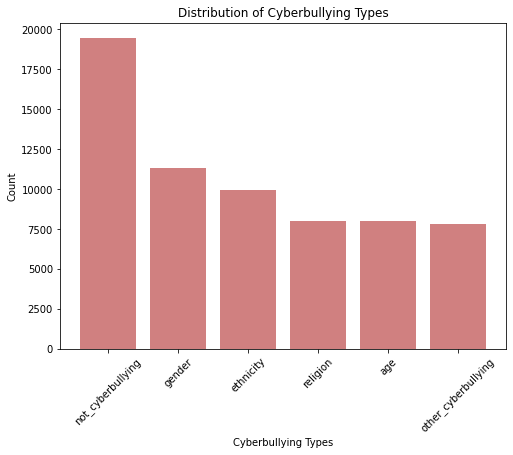

In [85]:
# Bar Plot of Cyberbullying Types
type_counts = data['type'].value_counts()
plt.figure(figsize=(8, 6))
plt.bar(type_counts.index, type_counts.values, color='#D08080')
plt.xlabel('Cyberbullying Types')
plt.ylabel('Count')
plt.title('Distribution of Cyberbullying Types')
plt.xticks(rotation=45)
plt.show()

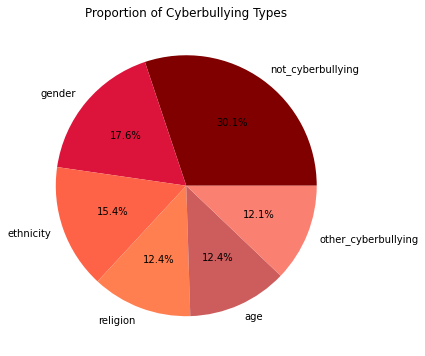

In [91]:
type_percentage = data['type'].value_counts(normalize=True) * 100
plt.figure(figsize=(8, 6))
plt.pie(type_percentage, labels=type_percentage.index, autopct='%1.1f%%', colors=['#800000', '#DC143C', '#FF6347', '#FF7F50', '#CD5C5C', '#FA8072'])
plt.title('Proportion of Cyberbullying Types')
plt.show()

In [128]:
text = ' '.join(data['text'].values).split()
words = [word for word in text if not word in stop_words]
word_counts = Counter(words)
top_words = word_counts.most_common(30)
top_words

[('school', 9208),
 ('rt', 7983),
 ('mkr', 7439),
 ('like', 6991),
 ('fuck', 6326),
 ('girl', 6127),
 ('im', 5913),
 ('nigger', 5638),
 ('people', 5608),
 ('joke', 5599),
 ('muslim', 5548),
 ("''", 5436),
 ('dumb', 5417),
 ('bully', 5329),
 ('dont', 5295),
 ('``', 5281),
 ('high', 5130),
 ('bullied', 4663),
 ('woman', 4461),
 ('one', 4398),
 ('gay', 4396),
 ('rape', 4348),
 ('get', 3823),
 ('idiot', 3585),
 ('amp', 3252),
 (')', 3223),
 ('know', 3021),
 ('black', 2916),
 ('think', 2905),
 ('make', 2725)]

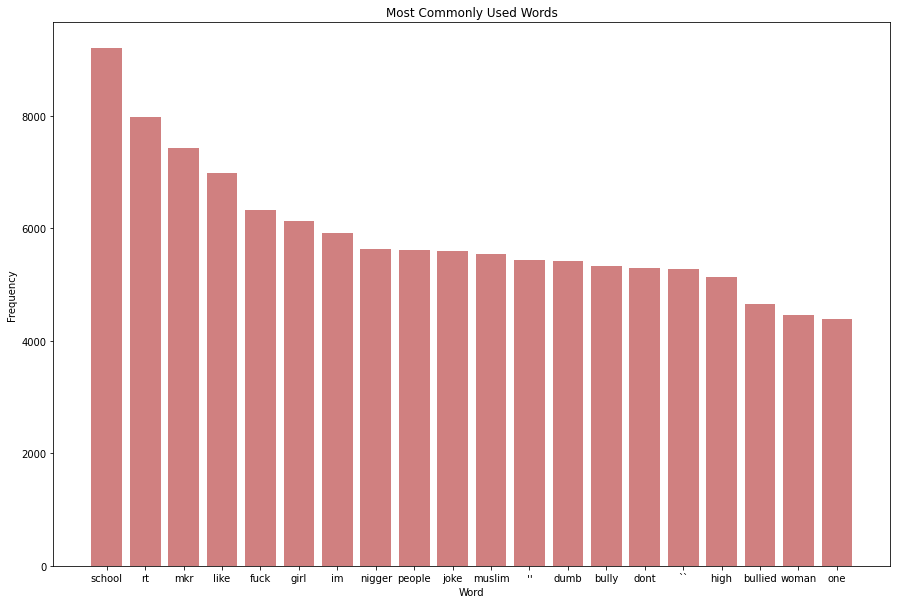

In [134]:
top_words = word_counts.most_common(20)
x_values = [word[0] for word in top_words]
y_values = [word[1] for word in top_words]
plt.figure(figsize=(15, 10))
plt.bar(x_values, y_values, color = '#D08080')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title('Most Commonly Used Words')
plt.show()

## MODEL SCORES

In [16]:
X, y = df['cleaned'], df['oh_label']

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(X).toarray()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
logreg = LogisticRegression(random_state=42)
logreg.fit(X_train, y_train)

logreg_pred = logreg.predict(X_test)

print("Logistic Regression accuracy:", accuracy_score(y_test, logreg_pred))

Logistic Regression accuracy: 0.8281899109792284


In [18]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

knn_pred = knn.predict(X_test)

print("K-Nearest Neighbors accuracy:", accuracy_score(y_test, knn_pred))

K-Nearest Neighbors accuracy: 0.7178041543026706


In [19]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

dt_pred = dt.predict(X_test)

print("Decision Tree accuracy:", accuracy_score(y_test, dt_pred))

Decision Tree accuracy: 0.7863501483679525


In [20]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

rf_pred = rf.predict(X_test)

print("Random Forest accuracy:", accuracy_score(y_test, rf_pred))

Random Forest accuracy: 0.8237388724035608


In [21]:
# vectorizer = CountVectorizer()
# X_train_vectorized = vectorizer.fit_transform(X_train)
# X_test_vectorized = vectorizer.transform(X_test)

classifier = MultinomialNB()
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8124629080118695


In [23]:
sentences = [simple_preprocess(doc) for doc in df['cleaned']]

phrases = Phrases(sentences, min_count=5, threshold=10)
bigram = Phraser(phrases)
sentences = [bigram[sentence] for sentence in sentences]

model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

vector = model.wv['hate']

similar_words = model.wv.most_similar('hate', topn=15)
print("Similar words to the word 'hate':")
for i, (word, probability) in enumerate(similar_words):
    print(f"{i+1}. {word}, {probability}")

Similar words to the word 'hate':
1. like, 0.9997395873069763
2. cant, 0.9997261762619019
3. girl, 0.9997059106826782
4. guy, 0.9996642470359802
5. say, 0.9996562004089355
6. dont, 0.9996477365493774
7. really, 0.9996388554573059
8. feminist, 0.9996387362480164
9. think, 0.9996307492256165
10. fucking, 0.9996284246444702
11. rt, 0.9996203184127808
12. notsexist, 0.9996185302734375
13. know, 0.9996165037155151
14. funny, 0.9995988011360168
15. there, 0.999591052532196


In [24]:
X = df['cleaned']
y = df['oh_label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

max_length = 100
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=max_length, padding='post')
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=max_length, padding='post')

num_classes = len(df['oh_label'].unique())
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=max_length))
model.add(LSTM(128))
model.add(Dense(64, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10, batch_size=32)

y_pred = model.predict(X_test)
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.argmax(y_test, axis=1)

accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)

Epoch 1/10
422/422 [==============================] - 50s 111ms/step - loss: 0.6287 - accuracy: 0.6822
Epoch 2/10
422/422 [==============================] - 48s 115ms/step - loss: 0.6268 - accuracy: 0.6822
Epoch 3/10
422/422 [==============================] - 49s 116ms/step - loss: 0.6263 - accuracy: 0.6822
Epoch 4/10
422/422 [==============================] - 51s 121ms/step - loss: 0.6265 - accuracy: 0.6822
Epoch 5/10
422/422 [==============================] - 50s 119ms/step - loss: 0.6257 - accuracy: 0.6822
Epoch 6/10
422/422 [==============================] - 50s 118ms/step - loss: 0.6257 - accuracy: 0.6822
Epoch 7/10
422/422 [==============================] - 50s 118ms/step - loss: 0.6254 - accuracy: 0.6822
Epoch 8/10
422/422 [==============================] - 51s 121ms/step - loss: 0.6257 - accuracy: 0.6822
Epoch 9/10
422/422 [==============================] - 47s 110ms/step - loss: 0.6257 - accuracy: 0.6822
Epoch 10/10
106/106 [==============================] - 5s 36ms/step
Accur

In [124]:
print(df['annotation'].value_counts(), '\n')

df.loc[df['annotation'] == 'none', 'annotation'] = 'not_cyberbullying'
df.loc[df['annotation'] == 'sexism', 'annotation'] = 'gender'
df.loc[df['annotation'] == 'racism', 'annotation'] = 'ethnicity'

print(df['annotation'].value_counts())

df = df.rename(columns={'annotation': 'type', 'cleaned': 'text'})
df = df[['text', 'type']]
df

none      11501
sexism     3377
racism     1970
Name: annotation, dtype: int64 

not_cyberbullying    11501
gender                3377
ethnicity             1970
Name: annotation, dtype: int64


,text,type
0,read contextno change meaning history islamic ...,not_cyberbullying
1,idiot claim people tried stop becoming terrori...,not_cyberbullying
2,rt call sexist go auto place id rather talk guy,gender
3,wrong isi follows example mohammed quran exactly,ethnicity
4,mkr,not_cyberbullying
...,...,...
16846,feeling sorry girl safe kat andre going home mkr,not_cyberbullying
16847,mkr pretty good dish happy - ok well im never ...,not_cyberbullying
16848,rt deconstructed lemon tartcan please go one s...,not_cyberbullying
16849,stupid talk blocked,not_cyberbullying


In [125]:
df2 = pd.read_csv(r'archive/cyberbullying_tweets.csv')

print(df2['cyberbullying_type'].value_counts())
df2 = df2.rename(columns={'tweet_text': 'text', 'cyberbullying_type': 'type'})

df2

religion               7998
age                    7992
gender                 7973
ethnicity              7961
not_cyberbullying      7945
other_cyberbullying    7823
Name: cyberbullying_type, dtype: int64


,text,type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying
...,...,...
47687,"Black ppl aren't expected to do anything, depe...",ethnicity
47688,Turner did not withhold his disappointment. Tu...,ethnicity
47689,I swear to God. This dumb nigger bitch. I have...,ethnicity
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,ethnicity


In [126]:
df2['text'] = df2['text'].apply(lambda x: cleaning(x))

data = df.append(df2)
data

,text,type
0,read contextno change meaning history islamic ...,not_cyberbullying
1,idiot claim people tried stop becoming terrori...,not_cyberbullying
2,rt call sexist go auto place id rather talk guy,gender
3,wrong isi follows example mohammed quran exactly,ethnicity
4,mkr,not_cyberbullying
...,...,...
47687,black ppl arent expected anything depended any...,ethnicity
47688,turner withhold disappointment turner called c...,ethnicity
47689,swear god dumb nigger bitch got bleach hair re...,ethnicity
47690,yea fuck rt youre nigger fucking unfollow fuck...,ethnicity


In [58]:
data["sentiment"] = data['type'].replace({"religion": 1, "age": 2, "ethnicity": 3, "gender": 4, "other_cyberbullying": 5,"not_cyberbullying": 6})

# X,y = data['text'], data['sentiment']
X,y = data['text'], data['type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify =y, random_state = 42)

In [59]:
tf_idf = TfidfVectorizer()
X_train_tf = tf_idf.fit_transform(X_train)
X_test_tf = tf_idf.transform(X_test)

In [61]:
log = LogisticRegression(random_state=42)
log.fit(X_train_tf, y_train)

log_pred = log.predict(X_test_tf)
# target_names = ["religion", "age", "gender", "ethnicity", "not bullying", "other bullying"]
print(classification_report(y_test, log_pred))

                     precision    recall  f1-score   support

                age       0.95      0.97      0.96      2398
          ethnicity       0.89      0.82      0.85      2979
             gender       0.89      0.78      0.83      3405
  not_cyberbullying       0.64      0.83      0.73      5834
other_cyberbullying       0.47      0.24      0.32      2347
           religion       0.82      0.84      0.83      2399

           accuracy                           0.77     19362
          macro avg       0.78      0.75      0.75     19362
       weighted avg       0.76      0.77      0.76     19362



In [62]:
nb_clf = MultinomialNB(alpha=0.5)
nb_clf.fit(X_train_tf,y_train)

nb_pred = nb_clf.predict(X_test_tf)

print(classification_report(y_test, nb_pred))

                     precision    recall  f1-score   support

                age       0.89      0.89      0.89      2398
          ethnicity       0.84      0.74      0.78      2979
             gender       0.84      0.76      0.80      3405
  not_cyberbullying       0.60      0.86      0.71      5834
other_cyberbullying       0.35      0.04      0.06      2347
           religion       0.73      0.80      0.76      2399

           accuracy                           0.72     19362
          macro avg       0.71      0.68      0.67     19362
       weighted avg       0.70      0.72      0.69     19362



In [72]:
test = tf_idf.transform(['that guy is shitty person probably muslim ass', "rape is the best solution for whores", "i love my mom so much"])
log.predict(test)

array(['religion', 'gender', 'not_cyberbullying'], dtype=object)

## REFERENCES:

https://www.kaggle.com/datasets/andrewmvd/cyberbullying-classification - second dataset on classification
https://github.com/NeelShah18/emot/blob/master/emot/emo_unicode.py - emoticons, their meanings and unicodes
https://www.kaggle.com/code/sndpkirwai/cyberbully-detection-text-classification - code example
https://www.rapidtables.com/web/color/RGB_Color.html - color charts
